### 2018/2019 - Task List 7

[Book](https://raw.githubusercontent.com/jonesgithub/book-1/master/ML%20Machine%20Learning-A%20Probabilistic%20Perspective.pdf)
[Advanced pyro guide](http://pyro.ai/examples/bayesian_regression_ii.html)

0. Fix task list 5 to be a proper linear model (check fixed code in base repository)
1. Reimplement Task List 5 creating guide function manualy
    - create apropriate parameters (mean and std for a and b, sigma - noise)
    - create probabilistic mode using pyro API
    - compute y using sampled a,b
2. Visualize data and learned function (as on Task List 5)
3. Use `AutoMultivariateNormal` guide function
    - all parameters of guide are from normal distribution
    - covariance matrix is not diagonal
4. Visualize results of `AutoMultivariateNormal` vs `AutoDiagonalNormal`


# Required imports

In [3]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

In [4]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

## Solutions

## Task 0 - Fix task list 5 to be a proper linear model (check fixed code in base repository)

In [5]:
class RegressionModel(nn.Module):
    def __init__(self):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.a = nn.Linear(1, 1, bias=False)
        self.b = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.a(x) + self.b

In [6]:
abalone = pd.read_csv('abalone.csv', header=None)
abalone.columns = ["sex", "length", "diameter", "height", "whole_height", 
                   "shucked_weight", "viscera_weight", "shell_weight", "class"]
x = torch.tensor(abalone.length)
y = torch.tensor(abalone.diameter)

x_data=x[:,None]
y_data=y[:,None]

count = x.numel()

In [7]:
def create_probabilistic_model():
    regression_model=RegressionModel()
    def probabilistic_model(x_data, y_data):
        # weight and bias priors
        a_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
        b_prior = pyro.distributions.Normal(2., 1000.)
        priors = {'a.weight': a_prior, 'b': b_prior}
        scale = pyro.sample("sigma", pyro.distributions.Uniform(0., 1000.))
        # lift module parameters to random variables sampled from the priors
        lifted_module = pyro.random_module("module", regression_model, priors)
        # sample a nn (which also samples w and b)
        lifted_reg_model = lifted_module()
        with pyro.plate("map", len(x_data)):
            # run the nn forward on data
            prediction_mean = lifted_reg_model(x_data).squeeze(-1)
            # condition on the observed data
            obs=pyro.sample("obs",
                        pyro.distributions.Normal(prediction_mean, scale),
                        obs=y_data)
            return prediction_mean
    return probabilistic_model


def train(guide):
    pyro.clear_param_store()
    num_iterations=3000
    model = create_probabilistic_model()
    guide = guide(model)
    optim = pyro.optim.Adam({"lr": 0.01})
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    t=tqdm(range(num_iterations))
    for j in t:
        loss = svi.step(x_data, y_data.squeeze(-1))
        t.set_postfix(loss=loss)
    return (model, svi)

In [8]:
def get_marginal(traces, sites):
    empirical_marginal=EmpiricalMarginal(traces, sites)
    return empirical_marginal._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        site_marginal=marginal[:, i]
        marginal_site = pd.DataFrame(site_marginal).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    model_result=probabilistic_model(x_data, y_data)
    pyro.sample("prediction", pyro.distributions.Delta(model_result))

In [7]:
def plot_regression():
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    x_values=x_data.squeeze().numpy()
    plt.plot(x_values, y_data.squeeze().numpy(), "bo")
    plt.plot(x_values, predictions['mu_mean'], 'r');
    aind = np.argsort(x_values)
    plt.fill_between(x_values[aind],
                       predictions["mu_perc_5"][aind],
                       predictions["mu_perc_95"][aind],
                       color='r',
                       alpha=0.5);
    plt.show()
    
    
def plot_distribution():
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    x_values=x_data.squeeze().numpy()
    plt.plot(x_values, y_data.squeeze().numpy(), "bo")
    plt.plot(x_values, predictions['y_mean'], 'r');
    aind = np.argsort(x_values)
    plt.fill_between(x_values[aind],
                       predictions["y_perc_5"][aind],
                       predictions["y_perc_95"][aind],
                       color='r',
                       alpha=0.5);
    plt.show()

## Task 4. Visualize results of `AutoMultivariateNormal` vs `AutoDiagonalNormal`

auto_loc tensor([-10.9632,  -0.0191,   0.8166], requires_grad=True)
auto_scale tensor([0.1297, 0.0033, 0.0047], grad_fn=<AddBackward0>)


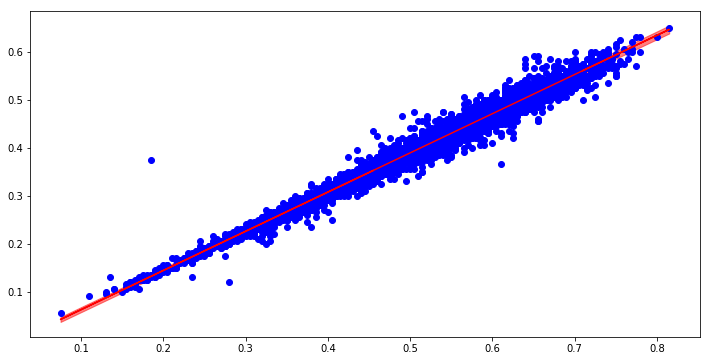

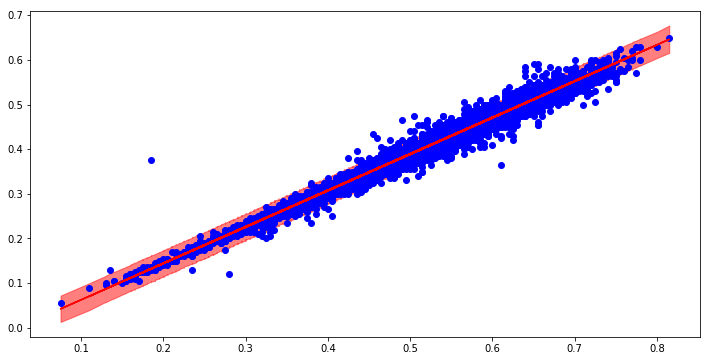

Wall time: 1min 51s


In [21]:
%%time
pyro.clear_param_store()

guide = AutoDiagonalNormal

probabilistic_model, svi = train(guide)
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plot_regression()
plot_distribution()

## Task 3 Use AutoMultivariateNormal guide function


auto_loc tensor([-9.3924, -0.0225,  0.8523], requires_grad=True)
auto_scale_tril tensor([[ 0.3428,  0.0000,  0.0000],
        [-0.0472,  0.2448,  0.0000],
        [ 0.0710, -0.4244,  0.0401]], grad_fn=<ViewBackward>)


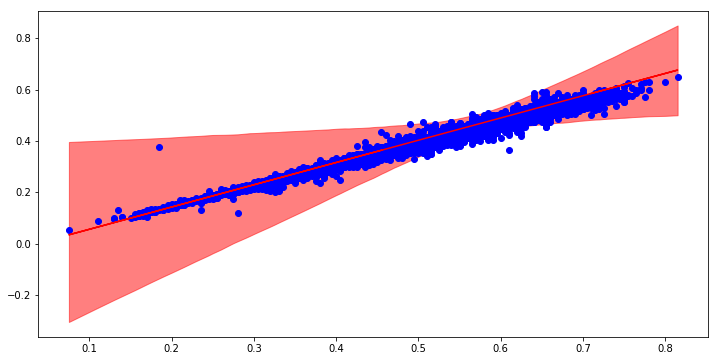

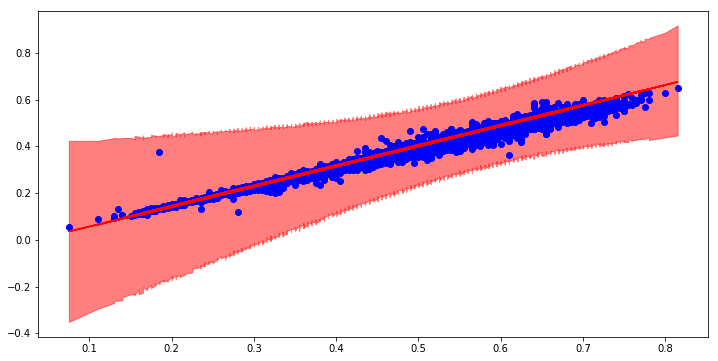

Wall time: 1min 56s


In [18]:
%%time
pyro.clear_param_store()

guide = AutoMultivariateNormal

probabilistic_model, svi = train(guide)
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plot_regression()
plot_distribution()

## Task 1 - Reimplement Task List 5 creating guide function manualy

In [10]:
def create_guide(model):
    regression_model=RegressionModel()
    def guide(x_data, y_data):
        a_loc = pyro.param('a_loc', torch.ones(1, 1)*0)
        a_scale = pyro.param('a_scale', torch.ones(1, 1)*1, 
                             constraint=constraints.positive)
        
        sigma_loc = pyro.param('sigma_loc', torch.tensor(1.), 
                               constraint=constraints.positive)
        
        b_loc = pyro.param('b_loc', torch.ones(1)*0)
        b_scale = pyro.param('b_scale', torch.ones(1)*1, 
                             constraint=constraints.positive)
        
        sigma = pyro.sample('sigma', dist.Normal(sigma_loc, torch.tensor(0.0005)))

        a_dist = dist.Normal(a_loc, a_scale).to_event(1)
        b_dist = dist.Normal(b_loc, b_scale)
        
        dists = {'a.weight': a_dist, 'b': b_dist}
        lifted_module = pyro.random_module("module", regression_model, dists)
        prediction_mean = lifted_module()
        return prediction_mean
    return guide


a_loc tensor([[0.8136]], requires_grad=True)
a_scale tensor([[0.0024]], grad_fn=<AddBackward0>)
sigma_loc tensor(0.0165, grad_fn=<AddBackward0>)
b_loc tensor([-0.0217], requires_grad=True)
b_scale tensor([0.0017], grad_fn=<AddBackward0>)


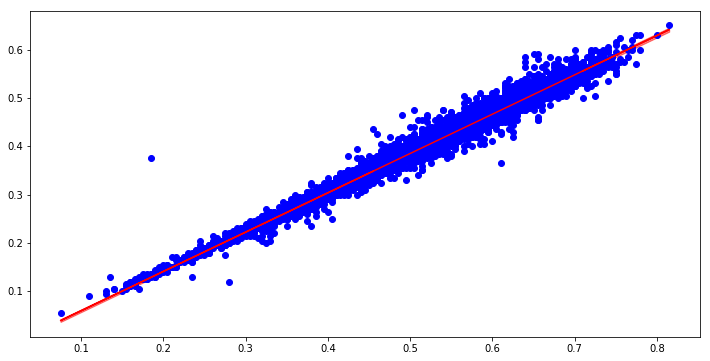

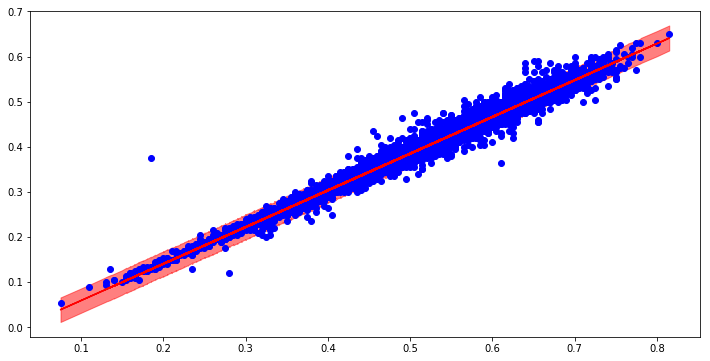

Wall time: 1min 31s


In [11]:
%%time
pyro.clear_param_store()

guide = create_guide

probabilistic_model, svi = train(guide)
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plot_regression()
plot_distribution()